In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
import time
np.random.seed(42)
random.seed(42)

In [2]:
df = pd.read_csv('processed_dataset.csv')
df.shape

(515738, 18)

<Axes: title={'center': 'Top 10 Reviewed Hotels'}, ylabel='Hotel_Name'>

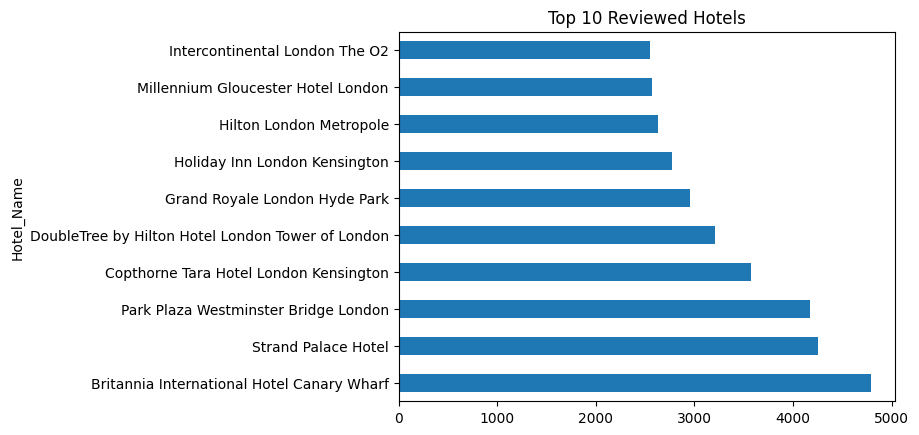

In [3]:
df['Hotel_Name'].value_counts().head(10).plot(kind='barh', title='Top 10 Reviewed Hotels')

<Axes: >

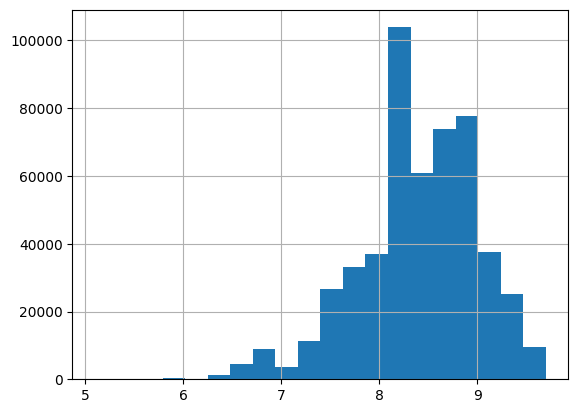

In [4]:
df['Calc_Average_Score'].hist(bins=20)

<Axes: ylabel='Reviewer_Nationality'>

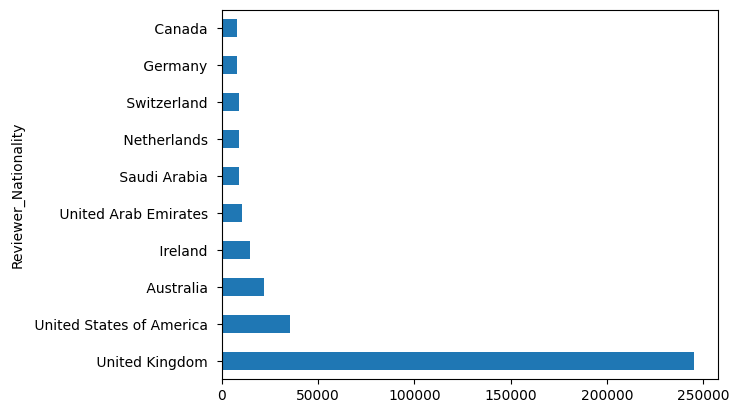

In [5]:
df['Reviewer_Nationality'].value_counts().head(10).plot(kind='barh')

<Axes: xlabel='Sentiment_Label', ylabel='Calc_Average_Score'>

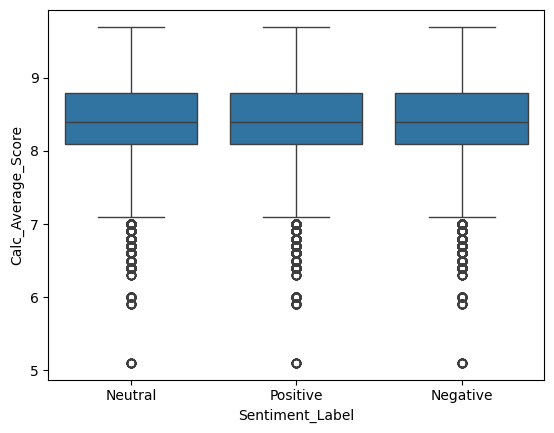

In [6]:
df['Sentiment_Label'] = np.random.choice(['Positive', 'Negative', 'Neutral'], size=len(df))

sns.boxplot(x='Sentiment_Label', y='Calc_Average_Score', data=df)

In [7]:
X= df.iloc[:,0:16].drop(df.columns[[7,0,2,4,5,6]], axis=1)

In [8]:
city_groups = df.groupby('Hotel_Address')
city_datasets = {city: city_df for city, city_df in city_groups}

Processing city: Amsterdam, Netherlands


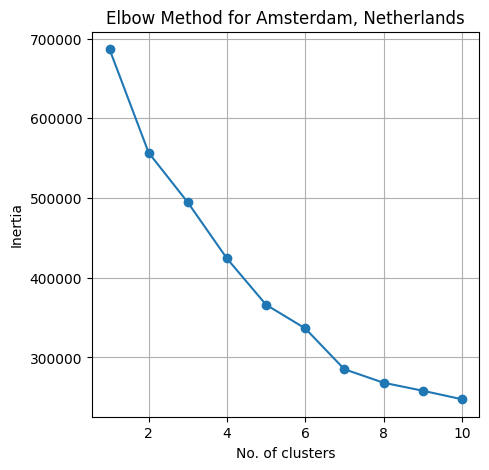

Processing city: Barcelona, Spain


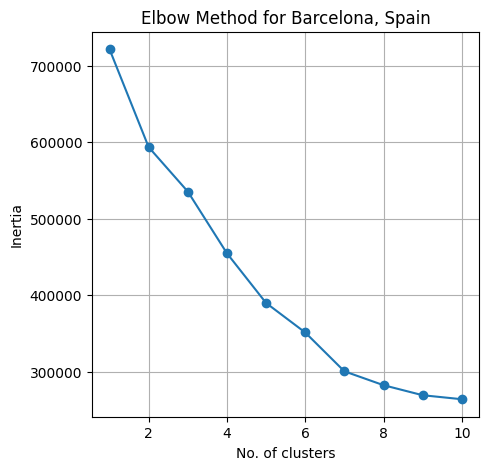

Processing city: London, United Kingdom


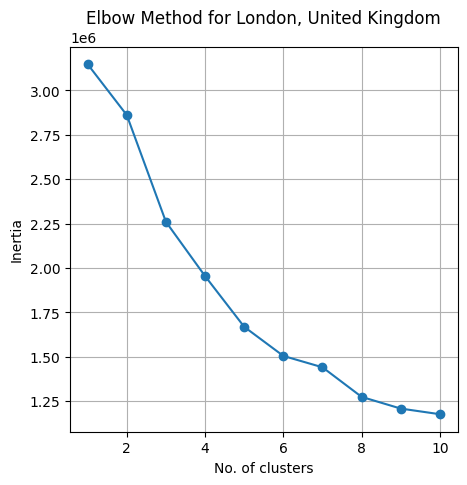

Processing city: Milan, Italy


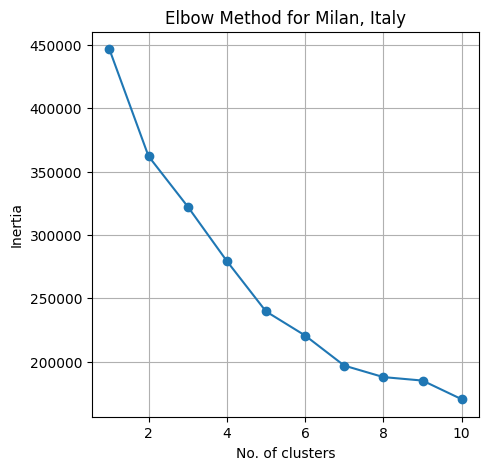

Processing city: Paris, France


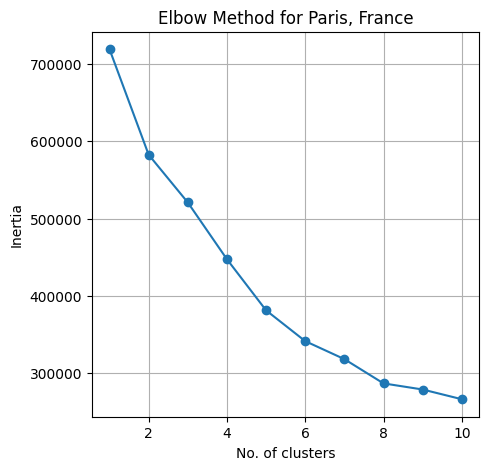

Processing city: Vienna, Austria


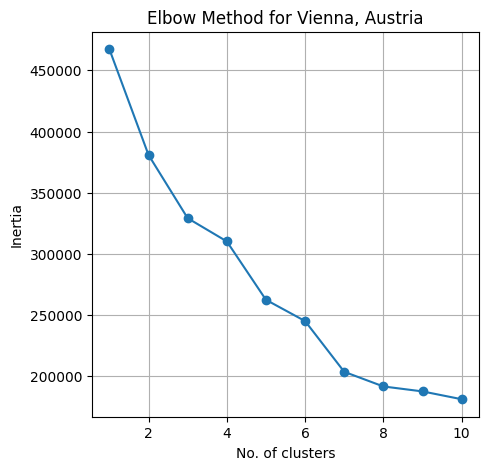

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

for city, city_df in city_datasets.items():
    print(f"Processing city: {city}")

    X = city_df.iloc[:, 2:15].drop(city_df.columns[7], axis=1)

    if 'Positive_Sentiment' in city_df.columns and 'Negative_Sentiment' in city_df.columns:
        X = X.copy()
        X['Positive_Sentiment'] = city_df['Positive_Sentiment']
        X['Negative_Sentiment'] = city_df['Negative_Sentiment']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(5,5))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title(f'Elbow Method for {city}')
    plt.xlabel('No. of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

city_k = {
    "Amsterdam, Netherlands": 8,
    "Barcelona, Spain": 9,
    "London, United Kingdom":8,
    "Milan, Italy": 8,
    "Paris, France": 7,
    "Vienna, Austria": 7
}

city_kmeans_models = {}

for city, city_df in city_datasets.items():
    print(f"Training KMeans for {city} with k = {city_k[city]}")

    X = city_df.iloc[:, 2:15].drop(city_df.columns[7], axis=1)

    if 'Positive_Sentiment' in city_df.columns and 'Negative_Sentiment' in city_df.columns:
        X = X.copy()
        X['Positive_Sentiment'] = city_df['Positive_Sentiment']
        X['Negative_Sentiment'] = city_df['Negative_Sentiment']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=city_k[city], random_state=42)
    kmeans.fit(X_scaled)

    city_kmeans_models[city] = {
        'model': kmeans,
        'labels': kmeans.labels_,
        'scaled_data': X_scaled,
        'original_data': city_df
    }

    print(f"{city} clustering complete.")


Training KMeans for Amsterdam, Netherlands with k = 8
Amsterdam, Netherlands clustering complete.
Training KMeans for Barcelona, Spain with k = 9
Barcelona, Spain clustering complete.
Training KMeans for London, United Kingdom with k = 8
London, United Kingdom clustering complete.
Training KMeans for Milan, Italy with k = 8
Milan, Italy clustering complete.
Training KMeans for Paris, France with k = 7
Paris, France clustering complete.
Training KMeans for Vienna, Austria with k = 7
Vienna, Austria clustering complete.


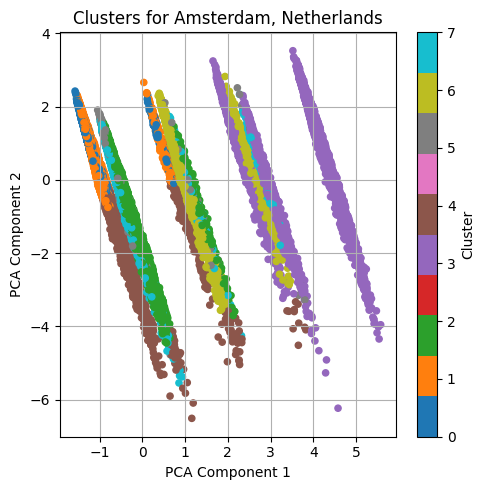

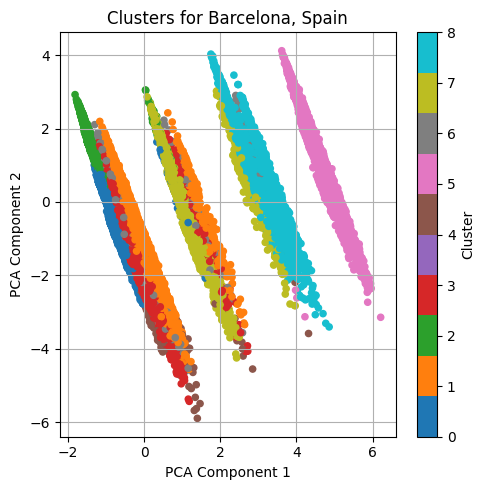

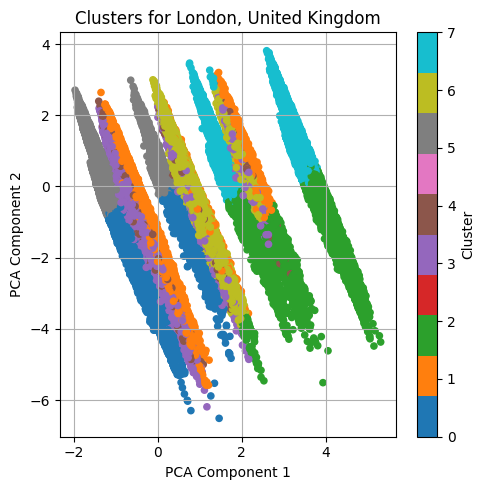

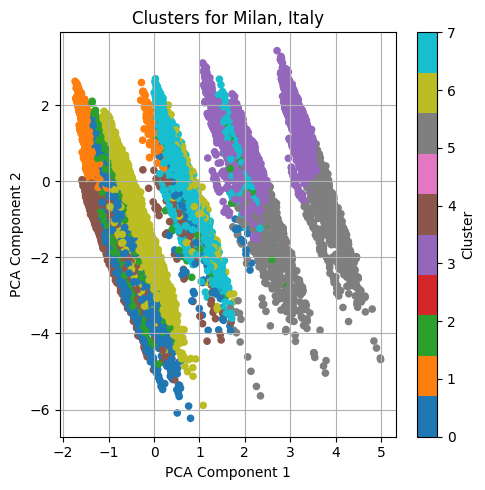

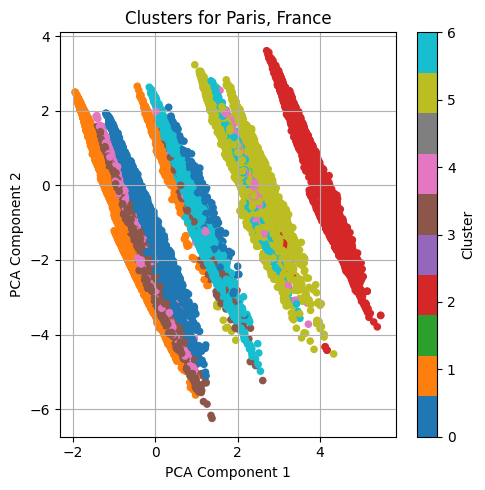

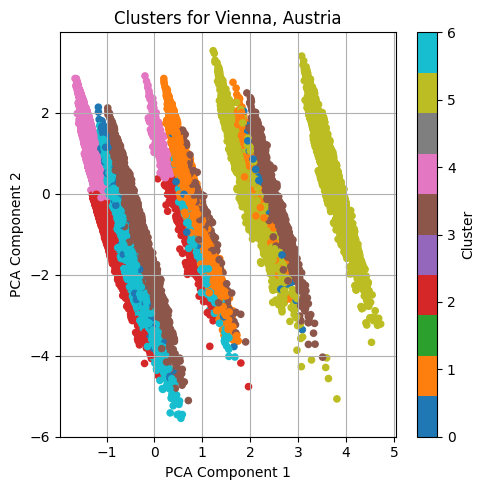

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

for city, info in city_kmeans_models.items():
    X_scaled = info['scaled_data']
    labels = info['labels']

    # Reduce features to 2D for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_scaled)

    plt.figure(figsize=(5, 5))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=20)
    plt.title(f'Clusters for {city}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def recommend_hotels(city_name, tag_preference, top_n=5):
    city_data = city_kmeans_models[city_name]['original_data']
    X_scaled = city_kmeans_models[city_name]['scaled_data']
    labels = city_kmeans_models[city_name]['labels']
    model = city_kmeans_models[city_name]['model']

    city_data = city_data.copy()
    city_data['Cluster'] = labels

    dummy = np.zeros(X_scaled.shape[1])
    tag_columns = city_data.columns[2:15].drop(city_data.columns[7])
    if tag_preference in tag_columns:
        idx = list(tag_columns).index(tag_preference)
        dummy[idx] = 1

    mean = X_scaled.mean(axis=0)
    std = X_scaled.std(axis=0)
    dummy_scaled = (dummy - mean) / std

    cluster_label = model.predict([dummy_scaled])[0]

    cluster_hotels = city_data[city_data['Cluster'] == cluster_label]

    recommended = cluster_hotels.sort_values(by='Average_Score', ascending=False).head(top_n)

    return recommended[['Hotel_Name', 'Average_Score', 'Tags', 'Reviewer_Nationality']]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ensure the 'Cluster' column is added to the original dataframes
for city, info in city_kmeans_models.items():
    if 'Cluster' not in info['original_data'].columns:
        info['original_data']['Cluster'] = info['labels']

# Create the cluster_summary dictionary
cluster_summary = {}
for city, city_df in city_datasets.items():
  print(f"\nCluster Summary for {city}")
  summary = city_df.groupby('Cluster').mean(numeric_only=True)
  print(summary)
  cluster_summary[city] = summary


Cluster Summary for Amsterdam, Netherlands
         Total_Number_of_Reviews  Calc_Average_Score  Reviewer_Score  \
Cluster                                                                
0                    5666.436047            8.714298        9.078348   
1                    1919.860376            8.589283        9.209844   
2                    3590.946297            8.388779        8.557774   
3                    3264.627691            8.408429        8.033718   
4                    2952.328669            8.005026        6.714577   
5                    3493.309614            8.495664        8.521913   
6                    3424.055634            8.456969        8.395913   
7                    3375.397573            8.438791        8.369148   

         Negative_Sentiment  Positive_Sentiment  Leisure_trip    Couple  \
Cluster                                                                   
0                  0.044543            0.698968      0.983958  1.000000   
1         

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def recommend_cluster(city, user_tags, city_cluster_summary_df):
    city_summary = city_cluster_summary_df

    # Define all potential tag columns
    all_tag_columns = ['Leisure_trip', 'Couple', 'Solo_traveler', 'Business_trip',
                       'Group', 'Family_with_young_children', 'Family_with_older_children',
                       'With_a_pet']

    # Filter tag columns to include only those present in the city_summary
    present_tag_columns = [col for col in all_tag_columns if col in city_summary.columns]

    if not present_tag_columns:
        print(f"Warning: No tag columns found in the cluster summary for {city}. Cannot perform tag-based recommendation.")
        return None, None # Or handle appropriately

    # Filter city_summary to include only the present tag columns
    city_summary_tags = city_summary[present_tag_columns]

    # Create a user preference vector aligned with the present tag columns
    user_preference_vector = pd.Series(user_tags)
    user_vector_aligned = user_preference_vector.reindex(present_tag_columns, fill_value=0)
    user_vector = user_vector_aligned.values.reshape(1, -1)

    similarities = cosine_similarity(city_summary_tags.values, user_vector).flatten()

    best_cluster = np.argmax(similarities)

    return best_cluster, similarities[best_cluster]

In [15]:
def recommend_hotels(city_df, cluster_label, top_n=5):
    recommendations = city_df[city_df['Cluster'] == cluster_label].copy() # Create a copy to avoid SettingWithCopyWarning
    recommendations = recommendations.sort_values(by='Calc_Average_Score', ascending=False)
    # Drop duplicate hotel names, keeping the one with the highest score if there are duplicates
    recommendations = recommendations.drop_duplicates(subset=['Hotel_Name'], keep='first')
    return recommendations.head(top_n)[['Hotel_Name', 'Calc_Average_Score']]

In [16]:
city = 'Paris, France' # Corrected city name
user_tags = {
    'Leisure_trip': 1,
    'Couple': 1,
    'Solo_traveler': 0,
    'Business_trip': 0,
    'Group': 0,
    'Family_with_young_children': 0,
    'Family_with_older_children': 0,
    'With_a_pet': 0,

}


cluster_id, similarity = recommend_cluster(city, user_tags, cluster_summary[city])
print(f"Matched Cluster: {cluster_id} with similarity {similarity:.2f}")

recommendations = recommend_hotels(city_datasets[city], cluster_id)
print("Top Hotel Recommendations:")
print(recommendations)

Matched Cluster: 1 with similarity 1.00
Top Hotel Recommendations:
                                 Hotel_Name  Calc_Average_Score
314655  H tel de La Tamise Esprit de France                 9.7
498444                Le Narcisse Blanc Spa                 9.7
31340                            Ritz Paris                 9.7
150909                         H tel Fabric                 9.6
515568                     H tel D Aubusson                 9.6
